In [16]:
# 📓 Notebook 03 – Avaliação Avançada, Ajuste e Salvamento do Melhor Modelo

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

In [17]:
# Carregando os dados e o scaler
df = pd.read_parquet("../data/dados_petr4.parquet")
scaler = joblib.load("../models/scaler_petr4.joblib")

In [18]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,6.612076,7.095887,6.532908,7.054836,104534800
2019-01-03,7.025514,7.277682,6.978599,7.227835,95206400
2019-01-04,7.286481,7.312871,7.175057,7.248362,72119800
2019-01-07,7.286480,7.600224,7.242497,7.362717,121711900
2019-01-08,7.447750,7.453614,7.263022,7.318733,68761800
...,...,...,...,...,...
2025-07-23,31.350000,32.029999,31.299999,31.990000,27418600
2025-07-24,31.930000,32.020000,31.650000,31.940001,17856300
2025-07-25,31.990000,32.180000,31.910000,31.980000,13341000


In [19]:
# Recriação das features
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)
df['ma_5'] = df['Close'].rolling(window=5).mean()
df['ma_10'] = df['Close'].rolling(window=10).mean()
df.dropna(inplace=True)

X = df[['Close_lag1', 'Close_lag2', 'Close_lag3', 'ma_5', 'ma_10']]
y = df['Close']
X_scaled = scaler.transform(X)

In [20]:
# Divisão temporal
split = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]


📊 LinearRegression:
RMSE: 0.31
MAE: 0.24
R²: 0.97


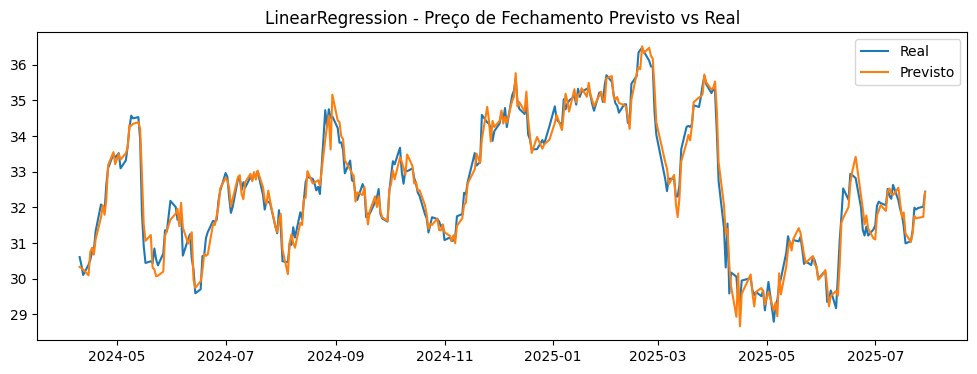


📊 Ridge:
RMSE: 0.63
MAE: 0.46
R²: 0.87


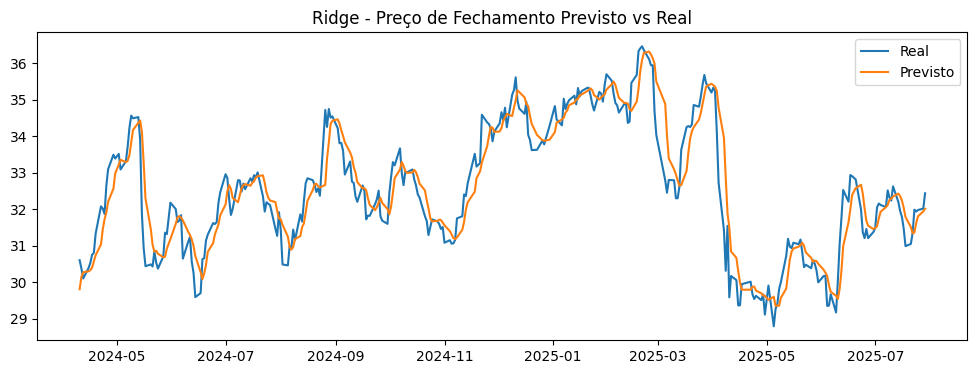


📊 Lasso:
RMSE: 1.37
MAE: 1.29
R²: 0.39


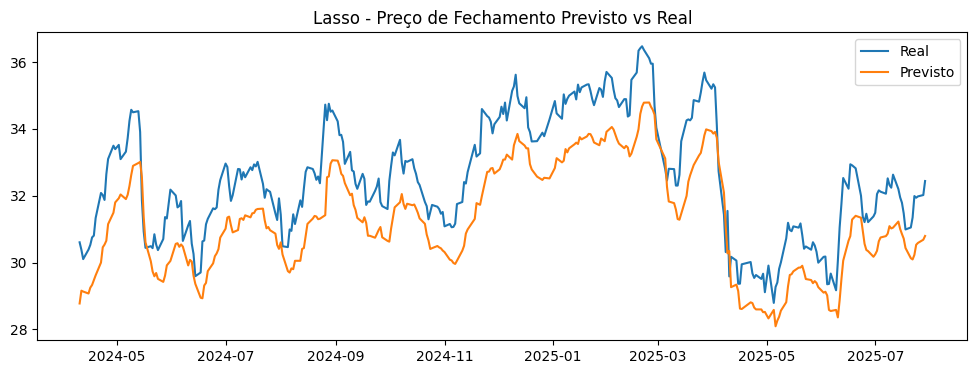


📊 ElasticNet:
RMSE: 4.15
MAE: 4.09
R²: -4.56


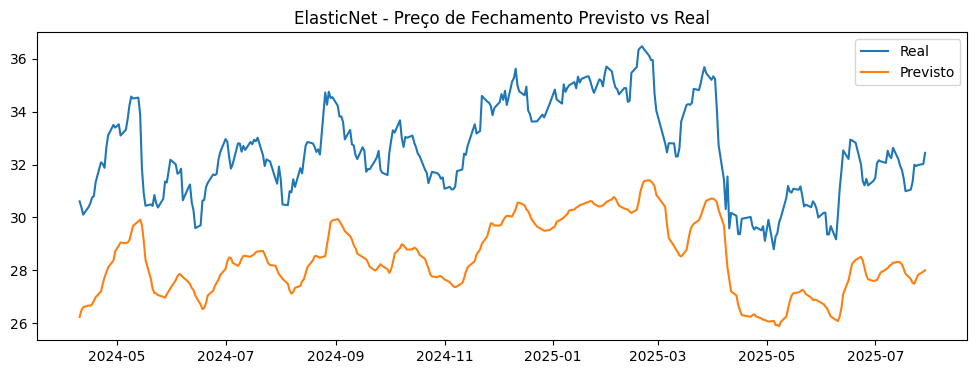

In [21]:
# Avaliação de diferentes modelos
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((name, model, rmse, mae, r2))

    print(f"\n📊 {name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    plt.figure(figsize=(12, 4))
    plt.plot(y_test.index, y_test.values, label='Real')
    plt.plot(y_test.index, y_pred, label='Previsto')
    plt.title(f'{name} - Preço de Fechamento Previsto vs Real')
    plt.legend()
    plt.show()


In [22]:
# Selecionando o melhor modelo (menor RMSE)
best_model_info = min(results, key=lambda x: x[2])

print("\n🏆 Melhor modelo encontrado:")
print(f"Modelo: {best_model_info[0]}")
print(f"RMSE: {best_model_info[2]:.2f}")
print(f"MAE: {best_model_info[3]:.2f}")
print(f"R²: {best_model_info[4]:.2f}")


🏆 Melhor modelo encontrado:
Modelo: LinearRegression
RMSE: 0.31
MAE: 0.24
R²: 0.97


In [ ]:
# Salvando o melhor modelo
joblib.dump(best_model_info[1], f"../models/melhor_modelo_{best_model_info[0].lower()}_petr4.joblib")
print(f"\n✅ Melhor modelo salvo como 'melhor_modelo_{best_model_info[0].lower()}_petr4.joblib'")


✅ Melhor modelo salvo como 'modelo_melhor_linearregression_petr4.joblib'


In [24]:
# Validação cruzada com o melhor modelo
print(f"\n⏱️ Validação Cruzada com TimeSeriesSplit ({best_model_info[0]})")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model_info[1], X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)

print(f"RMSE médio: {rmse_scores.mean():.2f}")
print(f"Desvio padrão: {rmse_scores.std():.2f}")



⏱️ Validação Cruzada com TimeSeriesSplit (LinearRegression)
RMSE médio: 0.24
Desvio padrão: 0.07
